# Table of Contents

1. [Problem Statement](#pstatement)
2. [Data Loading and Preprocessing](#dload)
3. [Data Spliting into train, valid, and test](#dsplit)
4. [Data Augmentation](#daugment)
5. [Model Building](#mbuild)
6. [Model Training](#mtrain)
7. [Model Testing](#mtest)
8. [Performance Visualization](#pvis)
9. [Performance Measures](#pmeasures)

# Problem Statement<a id='pstatement'><\a>
To implement an image degmentation pipeline using CNNs to get sementic understanding of the images.


**Monuseg dataset** (available [here](https://monuseg.grand-challenge.org/Data/)) is downloaded and the ground truth segmentation masks are created. The dataset can be either obtained from the instructor or can be downloaded from [this](https://drive.google.com/drive/folders/1hnHjxFb52BdhxkcV_N7MdWLdagzXHzmq?usp=sharing) Google Drive link.

In [1]:
#Imports the print function from newer versions of python
from __future__ import print_function

%tensorflow_version 1.x

from glob import glob
import numpy as np
import cv2

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

TensorFlow 1.x selected.


In [0]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras.layers import Input
from keras import backend as K

Using TensorFlow backend.


In [0]:
def load(image_path): #Load an image from a file path
    return cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2GRAY)

def display(image, title=None): # Show image
    plt.figure(figsize = (5,5))
    plt.imshow(image)
    plt.axis('off')
    if title: plt.title(title)
    plt.show()

# Data Loading and Preprocessing<a id='dload'><\a>

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
!unzip "/content/drive/My Drive/MonuSeg-dataset"

Archive:  /content/drive/My Drive/MonuSeg-dataset.zip
  inflating: MonuSeg/Test/GroundTruth/TCGA-AC-A2FO-01A-01-TS1_bin_mask.png  
  inflating: MonuSeg/Test/GroundTruth/TCGA-IZ-8196-01A-01-BS1_bin_mask.png  
  inflating: MonuSeg/Test/GroundTruth/TCGA-ZF-A9R5-01A-01-TS1_bin_mask.png  
  inflating: MonuSeg/Test/GroundTruth/TCGA-A6-6782-01A-01-BS1_bin_mask.png  
  inflating: MonuSeg/Test/GroundTruth/TCGA-2Z-A9J9-01A-01-TS1_bin_mask.png  
  inflating: MonuSeg/Test/GroundTruth/TCGA-HT-8564-01Z-00-DX1_bin_mask.png  
  inflating: MonuSeg/Test/GroundTruth/TCGA-44-2665-01B-06-BS6_bin_mask.png  
  inflating: MonuSeg/Test/GroundTruth/TCGA-EJ-A46H-01A-03-TSC_bin_mask.png  
  inflating: MonuSeg/Test/GroundTruth/TCGA-69-7764-01A-01-TS1_bin_mask.png  
  inflating: MonuSeg/Test/GroundTruth/TCGA-GL-6846-01A-01-BS1_bin_mask.png  
  inflating: MonuSeg/Test/GroundTruth/TCGA-CU-A0YN-01A-02-BSB_bin_mask.png  
  inflating: MonuSeg/Test/GroundTruth/TCGA-FG-A4MU-01B-01-TS1_bin_mask.png  
  inflating: MonuSeg/T

In [0]:
files_path = "./MonuSeg"

loading..


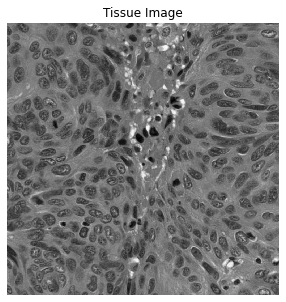

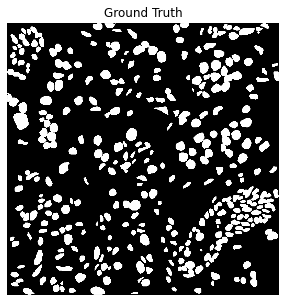

Train data of size: (30, 1024, 1024, 1) loaded!


In [8]:
# load training set
X_train, Y_train = [], []

print ("loading..")

for image_path in glob(files_path+'/Training/TissueImages/*'):
    X_train.append(cv2.resize(load(image_path), (1024, 1024)))
display(X_train[-1], "Tissue Image") # display the last read image

for image_path in glob(files_path+'/Training/GroundTruth/*'):
    Y_train.append(cv2.resize(load(image_path), (1024, 1024)))
display(Y_train[-1], "Ground Truth") # display the last read image

X_train = np.array(X_train, dtype="float") / 255.0
Y_train = np.array(Y_train, dtype="float") / 255.0

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
Y_train = Y_train.reshape((Y_train.shape[0], Y_train.shape[1], Y_train.shape[2], 1))

print ("Train data of size: {} loaded!".format(X_train.shape))

loading..


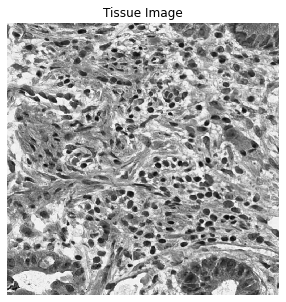

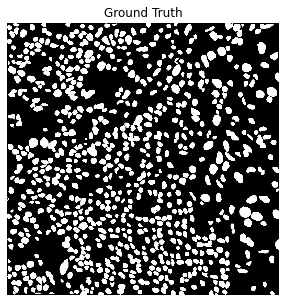

Test data of size: (14, 1024, 1024, 1) loaded!


In [9]:
# load testing set
X_test, Y_test = [], []

print ("loading..")

for image_path in glob(files_path+'/Test/TissueImages/*'):
    X_test.append(cv2.resize(load(image_path), (1024, 1024)))
display(X_test[-1], "Tissue Image") # display the last read image

for image_path in glob(files_path+'/Test/GroundTruth/*'):
    Y_test.append(cv2.resize(load(image_path), (1024, 1024)))
display(Y_test[-1], "Ground Truth") # display the last read image

X_test = np.array(X_test, dtype="float") / 255.0
Y_test = np.array(Y_test, dtype="float") / 255.0

X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))
Y_test = Y_test.reshape((Y_test.shape[0], Y_test.shape[1], Y_test.shape[2], 1))

# round the float values in Y_test added to it by cv2.resize
Y_test = Y_test.round(0)

print ("Test data of size: {} loaded!".format(X_test.shape))

# Data Spliting<a id='dsplit'><\a>
Split the training data into training, and validation sets.

In [0]:
# split the training set to training and validation sets with the ratio 80:20
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.20, random_state=42)

In [11]:
print ("X_train: ", np.shape(X_train), "\nY_train: ", np.shape(Y_train))
print ("X_valid: ", np.shape(X_valid), "\nY_valid: ", np.shape(Y_valid))
print ("X_test: ", np.shape(X_test), "\nY_test: ", np.shape(Y_test))

X_train:  (24, 1024, 1024, 1) 
Y_train:  (24, 1024, 1024, 1)
X_valid:  (6, 1024, 1024, 1) 
Y_valid:  (6, 1024, 1024, 1)
X_test:  (14, 1024, 1024, 1) 
Y_test:  (14, 1024, 1024, 1)


# Data Augmentation<a id='daugment'><\a>
Apply different transformations to the data to increase its diversity.

In [0]:
BATCHSIZE = 3 # batch size

In [0]:
# 'augmentor' is the image data generator for data augmentation
augmentor = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
                               height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                               horizontal_flip=True, fill_mode="nearest")

# 'augmented_train_data' is the augmented training set
augmented_train_data = augmentor.flow(X_train, Y_train, batch_size=BATCHSIZE)

# 'augmented_valid_data' is the augmented validation set
augmented_valid_data = augmentor.flow(X_valid, Y_valid, batch_size=BATCHSIZE)

# Model Building<a id='mbuild'><\a>

![SegNet Architecture](https://www.researchgate.net/profile/Vijay_Badrinarayanan/publication/283471087/figure/fig1/AS:391733042008065@1470407843299/An-illustration-of-the-SegNet-architecture-There-are-no-fully-connected-layers-and-hence.png)

In [15]:
class SegNet:
    def __init__(self):
        pass

    def encoder(self, input_layer, depth=2):
        encoded_out = Conv2D(depth, (3, 3), activation='relu', padding="same")(input_layer)
        encoded_out = BatchNormalization(axis=-1)(encoded_out)
        encoded_out = Conv2D(depth, (3, 3), activation='relu', padding="same")(encoded_out)
        encoded_out = BatchNormalization(axis=-1)(encoded_out)
        encoded_out = MaxPooling2D(pool_size=(2, 2))(encoded_out)

        encoded_out = Conv2D(2*depth, (3, 3), activation='relu', padding="same")(encoded_out)
        encoded_out = BatchNormalization(axis=-1)(encoded_out)
        encoded_out = Conv2D(2*depth, (3, 3), activation='relu', padding="same")(encoded_out)
        encoded_out = BatchNormalization(axis=-1)(encoded_out)
        encoded_out = MaxPooling2D(pool_size=(2, 2))(encoded_out)

        encoded_out = Conv2D(4*depth, (3, 3), activation='relu', padding="same")(encoded_out)
        encoded_out = BatchNormalization(axis=-1)(encoded_out)
        encoded_out = Conv2D(4*depth, (3, 3), activation='relu', padding="same")(encoded_out)
        encoded_out = BatchNormalization(axis=-1)(encoded_out)
        encoded_out = Conv2D(4*depth, (3, 3), activation='relu', padding="same")(encoded_out)
        encoded_out = BatchNormalization(axis=-1)(encoded_out)
        encoded_out = MaxPooling2D(pool_size=(2, 2))(encoded_out)

        encoded_out = Conv2D(8*depth, (3, 3), activation='relu', padding="same")(encoded_out)
        encoded_out = BatchNormalization(axis=-1)(encoded_out)
        encoded_out = Conv2D(8*depth, (3, 3), activation='relu', padding="same")(encoded_out)
        encoded_out = BatchNormalization(axis=-1)(encoded_out)
        encoded_out = Conv2D(8*depth, (3, 3), activation='relu', padding="same")(encoded_out)
        encoded_out = BatchNormalization(axis=-1)(encoded_out)
        encoded_out = MaxPooling2D(pool_size=(2, 2))(encoded_out)

        encoded_out = Conv2D(8*depth, (3, 3), activation='relu', padding="same")(encoded_out)
        encoded_out = BatchNormalization(axis=-1)(encoded_out)
        encoded_out = Conv2D(8*depth, (3, 3), activation='relu', padding="same")(encoded_out)
        encoded_out = BatchNormalization(axis=-1)(encoded_out)
        encoded_out = Conv2D(8*depth, (3, 3), activation='relu', padding="same")(encoded_out)
        encoded_out = BatchNormalization(axis=-1)(encoded_out)
        encoded_out = MaxPooling2D(pool_size=(2, 2))(encoded_out)

        return encoded_out

    def decoder(self, encoded_out, depth=2):
        decoded_out = UpSampling2D(size=(2, 2))(encoded_out)
        decoded_out = Conv2D(8*depth, (3, 3), activation='relu', padding="same")(decoded_out)
        decoded_out = BatchNormalization(axis=-1)(decoded_out)
        decoded_out = Conv2D(8*depth, (3, 3), activation='relu', padding="same")(decoded_out)
        decoded_out = BatchNormalization(axis=-1)(decoded_out)
        decoded_out = Conv2D(8*depth, (3, 3), activation='relu', padding="same")(decoded_out)
        decoded_out = BatchNormalization(axis=-1)(decoded_out)

        decoded_out = UpSampling2D(size=(2, 2))(decoded_out)
        decoded_out = Conv2D(8*depth, (3, 3), activation='relu', padding="same")(decoded_out)
        decoded_out = BatchNormalization(axis=-1)(decoded_out)
        decoded_out = Conv2D(8*depth, (3, 3), activation='relu', padding="same")(decoded_out)
        decoded_out = BatchNormalization(axis=-1)(decoded_out)
        decoded_out = Conv2D(8*depth, (3, 3), activation='relu', padding="same")(decoded_out)
        decoded_out = BatchNormalization(axis=-1)(decoded_out)

        decoded_out = UpSampling2D(size=(2, 2))(decoded_out)
        decoded_out = Conv2D(4*depth, (3, 3), activation='relu', padding="same")(decoded_out)
        decoded_out = BatchNormalization(axis=-1)(decoded_out)
        decoded_out = Conv2D(4*depth, (3, 3), activation='relu', padding="same")(decoded_out)
        decoded_out = BatchNormalization(axis=-1)(decoded_out)
        decoded_out = Conv2D(4*depth, (3, 3), activation='relu', padding="same")(decoded_out)
        decoded_out = BatchNormalization(axis=-1)(decoded_out)

        decoded_out = UpSampling2D(size=(2, 2))(decoded_out)
        decoded_out = Conv2D(2*depth, (3, 3), activation='relu', padding="same")(decoded_out)
        decoded_out = BatchNormalization(axis=-1)(decoded_out)
        decoded_out = Conv2D(2*depth, (3, 3), activation='relu', padding="same")(decoded_out)
        decoded_out = BatchNormalization(axis=-1)(decoded_out)

        decoded_out = UpSampling2D(size=(2, 2))(decoded_out)
        decoded_out = Conv2D(depth, (3, 3), activation='relu', padding="same")(decoded_out)
        decoded_out = BatchNormalization(axis=-1)(decoded_out)
        decoded_out = Conv2D(depth, (3, 3), activation='relu', padding="same")(decoded_out)
        decoded_out = BatchNormalization(axis=-1)(decoded_out)

        return decoded_out

    def SegNet(self, input_shape):
        depth = 32
        input_layer = Input(shape=input_shape)
        encoded_out = self.encoder(input_layer, depth)
        decoded_out = self.decoder(encoded_out, depth)
        decoded_out = Dense(1, activation="sigmoid")(decoded_out)
        model = Model(input_layer, decoded_out)
        return model

model = SegNet().SegNet(input_shape=(X_train[0].shape))

In [16]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1024, 1024, 1)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1024, 1024, 32)    320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024, 1024, 32)    128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1024, 1024, 32)    9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 1024, 1024, 32)    128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 512, 512, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 512, 512, 64)      1849

# Model Training<a id='mtrain'><\a>

In [36]:
INIT_LR = 0.01 # initial learning rate
EPOCHS = 100 # number of epocks

def dice_score(y_true, y_pred):
    y_true_f, y_pred_f = K.flatten(y_true), K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    summation = K.sum(y_true_f) + K.sum(y_pred_f)
    return (2.0 * intersection + K.epsilon()) / (summation + K.epsilon())

def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())

    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())

    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# compile the model
model.compile(loss="binary_crossentropy", optimizer="sgd", metrics=["accuracy", f1_score, dice_score])
 
# train the network using augmented data
H = model.fit_generator(augmented_train_data, validation_data=augmented_valid_data,
                        steps_per_epoch=len(X_train)//BATCHSIZE, epochs=EPOCHS)

Epoch 1/100
8/8 [==============================] - 16s 2s/step - loss: 0.6887 - acc: 0.5682 - f1_score: 0.2628 - dice_score: 0.3219 - val_loss: 0.7184 - val_acc: 0.5586 - val_f1_score: 0.2748 - val_dice_score: 0.3218
Epoch 2/100
8/8 [==============================] - 12s 1s/step - loss: 0.6811 - acc: 0.5764 - f1_score: 0.2567 - dice_score: 0.3200 - val_loss: 0.8216 - val_acc: 0.5425 - val_f1_score: 0.2961 - val_dice_score: 0.3305
Epoch 3/100
8/8 [==============================] - 12s 2s/step - loss: 0.6746 - acc: 0.5840 - f1_score: 0.2480 - dice_score: 0.3175 - val_loss: 0.6979 - val_acc: 0.5723 - val_f1_score: 0.2602 - val_dice_score: 0.3180
Epoch 4/100
8/8 [==============================] - 12s 1s/step - loss: 0.6688 - acc: 0.5905 - f1_score: 0.2381 - dice_score: 0.3142 - val_loss: 0.6892 - val_acc: 0.5817 - val_f1_score: 0.2554 - val_dice_score: 0.3170
Epoch 5/100
8/8 [==============================] - 12s 1s/step - loss: 0.6634 - acc: 0.5975 - f1_score: 0.2320 - dice_score: 0.3135 

# Model Testing<a id='mtest'><\a>

In [0]:
# evaluate the network
predictions = model.predict(X_test, batch_size=BATCHSIZE)

In [38]:
test_loss, test_acc, test_dice_score, test_f1_score = model.evaluate(X_test, Y_test)
test_loss, test_acc, test_dice_score, test_f1_score

14/14 [==============================] - 2s 154ms/step


(0.5253812670707703,
 0.7948024868965149,
 0.028451278805732727,
 0.23359370231628418)

# Performance Visualization<a id='pvis'><\a>

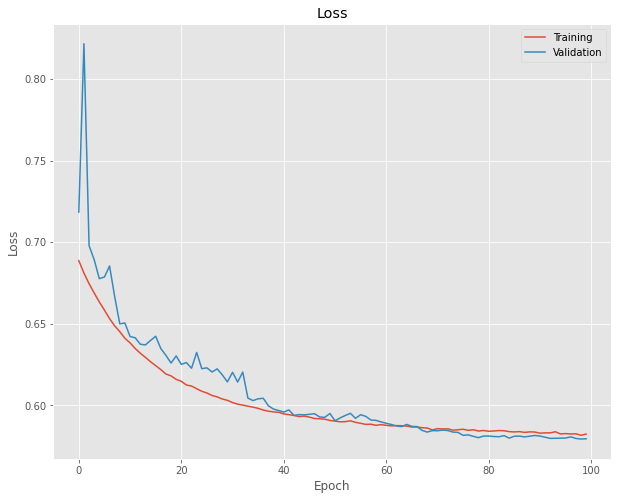

In [39]:
# plot the training and validation losses
N = np.arange(0, EPOCHS)
plt.figure()
plt.plot(N, H.history["loss"], label="Training")
plt.plot(N, H.history["val_loss"], label="Validation")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig("segnet_basic_loss_plot.png")
plt.show()

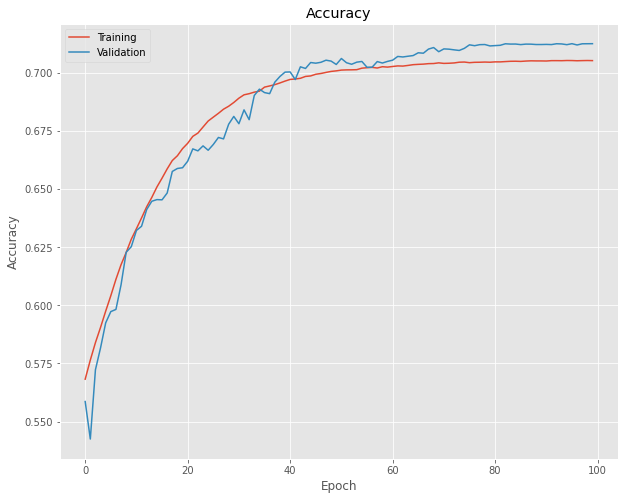

In [40]:
# plot the training and validation accuracies
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["acc"], label="Training")
plt.plot(N, H.history["val_acc"], label="Validation")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("segnet_basic_accuracy_plot.png")
plt.show()

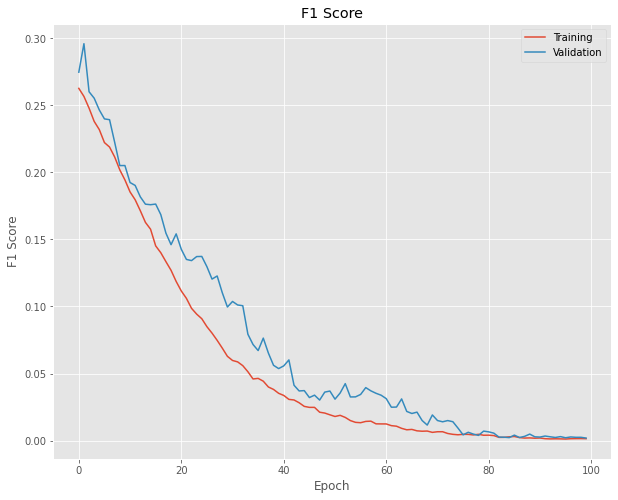

In [54]:
# plot the training and validation accuracies
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["f1_score"], label="Training")
plt.plot(N, H.history["val_f1_score"], label="Validation")
plt.title("F1 Score")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.legend()
plt.savefig("segnet_basic_f1_score_plot.png")
plt.show()

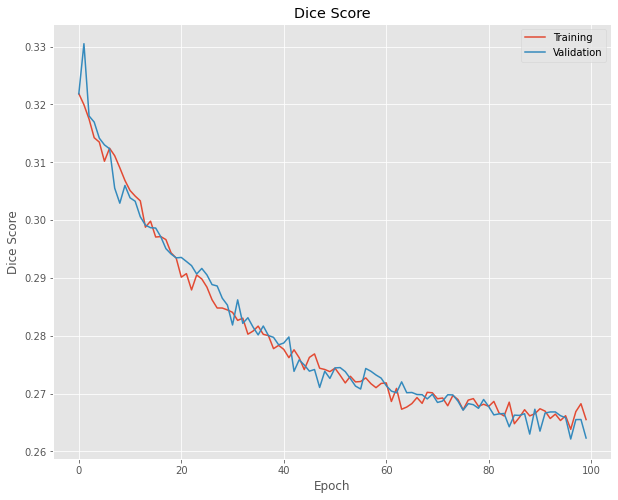

In [41]:
# plot the training and validation accuracies
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["dice_score"], label="Training")
plt.plot(N, H.history["val_dice_score"], label="Validation")
plt.title("Dice Score")
plt.xlabel("Epoch")
plt.ylabel("Dice Score")
plt.legend()
plt.savefig("segnet_basic_dice_score_plot.png")
plt.show()

In [0]:
# save the model for future use or deployment
model.save("segnet_basic.model")

# Performance Measures<a id='pmeasures'><\a>

In [0]:
TN, FP, FN, TP = confusion_matrix(Y_test.flatten().astype(int),
                             predictions.round(0).flatten().astype(int)).ravel()

In [59]:
TN, FP, FN, TP

(11623646, 158273, 2854037, 44108)

In [61]:
TN/TP

263.52693388954384

In [62]:
FN/FP

18.0323681234323

## Accuracy
It is defined as $accuracy = \frac{TP+TN}{TP+FP+TN+FN}$.

In [45]:
print ("Accuracy:", round((TP+TN)/(TP+FP+TN+FN)*100, 2))

Accuracy: 79.48


In [46]:
print ("Accuracy:", round(test_acc*100, 2))

Accuracy: 79.48


## F1 Score

It is defined as the harmonic mean of precision and recall as $F_1=\frac{2}{\frac{1}{precision}+\frac{1}{recall}}$ where $precision=\frac{TP}{TP+FP}$ and $recall=\frac{TP}{TP+FN}$.

In [47]:
precision, recall = TP/(TP+FP), TP/(TP+FN)
print ("F1 Score:", round(2.0/(1.0/precision+1.0/recall), 4))

F1 Score: 0.0285


In [48]:
print ("F1 Score:", round(test_f1_score, 2))

F1 Score: 0.23


##Dice Score
It is defined as $DSC = \frac{2\times{TP}}{2\times{TP}+FP+FN}$.

In [49]:
print ("Dice score:", round((2.0*TP)/(2*TP+FP+FN), 4))

Dice score: 0.0285


In [50]:
print ("Dice score:", round(test_dice_score, 4))

Dice score: 0.0285


# Classification Report

In [51]:
print (classification_report(Y_test.round(0).flatten().astype(int), predictions.round(0).flatten().astype(int)))

              precision    recall  f1-score   support

           0       0.80      0.99      0.89  11781919
           1       0.22      0.02      0.03   2898145

    accuracy                           0.79  14680064
   macro avg       0.51      0.50      0.46  14680064
weighted avg       0.69      0.79      0.72  14680064



# Confusion Matrix

In [52]:
Confusion_Matrix = confusion_matrix(Y_test.round(0).flatten().astype(int), predictions.round(0).flatten().astype(int))
Confusion_Matrix

array([[11623646,   158273],
       [ 2854037,    44108]])

# Qualitative Results

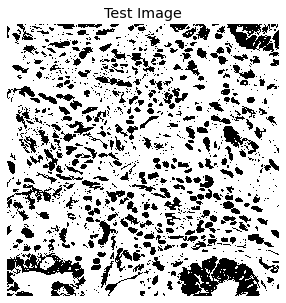

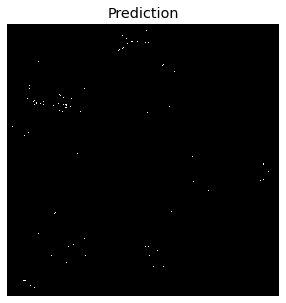

In [53]:
display(X_test[-1].reshape((1024, 1024)).round(0), "Test Image")
display(predictions[-1].reshape((1024, 1024)).round(0), "Prediction")